In [1]:
%pip install pandas
%pip install thefuzz
%pip install scipy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Текстовая коллекция news-shevard.xml
парсинг в json

In [2]:

import xml.etree.ElementTree as etree
import base64
import json

with open('news-shevard.xml', 'r') as xml_file:
    tree = etree.parse(xml_file)
root = tree.getroot()

documents = root.findall("./{http://www.romip.ru/data/common}document")

titles = []
for document in documents:
    for subject in document.iter('{http://www.romip.ru/data/common}subject'):
        string_bytes = subject.text
        string = base64.b64decode(string_bytes).decode('windows-1251')
        titles.append(string)

file = open("text.json", "w", encoding="utf-8")
file.write("{\n")
idx = 0
for title in titles:
    file.write("\"{}\": \"{}\",".format(idx, title.replace("\"", "\\\"")) + "\n")
    idx += 1

file.write("}")
file.close()

## Чтение в Df

In [3]:
import pandas as pd

data = pd.read_json("text.json", typ='series')[:50]
print(data.to_string())

0     Председатель Комитета Госдумы России по делам ...
1              50% продавцов Казани не имеют спецодежды
2     Одним из поставщиков газа на рынки Свердловско...
3     Повестка дня на 18 ноября - Тюменская область,...
4     Задолженность сельхозпредприятий Вельского рай...
5     Кандидат в депутаты Госудумы Александр Сарычев...
6     Вопрос с контрактом Ярцева будет решен после 1...
7     Алтайские предприниматели примут участие в фор...
8     В Кирове проведены проверки предприятий по соб...
9     В Смоленской области засеяно 74 процента площа...
10                   В Смоленске прошла декада качества
11    В Тульской области 80 метров железнодорожного ...
12    В Смоленской области подведены итоги операции ...
13    Объемы строительных работ выросли в 7 районах ...
14    Губернатор Новгородской области провел прием г...
15    Городские власти Смоленска обещают помочь бизн...
16    Красноярский завод комбайнов организует курс п...
17    В Великом Новгороде завершился турнир по х

In [4]:
from pymorphy3 import MorphAnalyzer
import nltk
from nltk.corpus import stopwords

an = MorphAnalyzer(lang='ru')
stops = stopwords.words('russian')

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

def getClearSentences(sentences):
    return " ".join(str(s) + "" for s in (an.normal_forms(y)[0] for y in filter(lambda x: x not in stops, tokenizer.tokenize(str(sentences)))))

documents = data.apply(lambda x: getClearSentences(x))
non_affected_documents = data.copy()
documents

0     председатель комитет госдума россия дело снг с...
1                   50 продавец казань иметь спецодежда
2     один поставщик газ рынок свердловский область ...
3     повестка день 18 ноябрь тюменский область югра...
4     задолженность сельхозпредприятие вельский райо...
5     кандидат депутат госудума александр сарычев вс...
6               вопрос контракт ярцев решить 17 декабрь
7     алтайский предприниматель принять участие фору...
8     в киров провести проверка предприятие соблюден...
9     в смоленский область засеять 74 процент площад...
10                    в смоленск пройти декада качество
11    в тульский область 80 метр железнодорожный пут...
12    в смоленский область подвести итог операция по...
13    объём строительный работа вырасти 7 район смол...
14    губернатор новгородский область провести приём...
15    городской власть смоленск обещать помочь бизне...
16    красноярский завод комбайн организовать курс п...
17    в великий новгород завершиться турнир худо

In [5]:
SHINGLE_LEN = 3

from nltk.util import ngrams

shingles = []

for i in range(0, len(documents)):
    shingles.append(list(map(list, ngrams(nltk.word_tokenize(documents[i]), SHINGLE_LEN))))

In [6]:
import numpy as np
from thefuzz import fuzz

similarity_matrix = np.zeros((len(documents), len(documents)))

for i in range(len(documents)):
    for j in range(i + 1, len(documents)):
        shingles_i = shingles[i]
        shingles_j = shingles[j]

        shingle_similarities = [fuzz.ratio(shingle_i, shingle_j) for shingle_i in shingles_i for shingle_j in shingles_j]
        similarity = np.mean(shingle_similarities)
        
        similarity_matrix[i][j] = similarity
        similarity_matrix[j][i] = similarity

C:\Users\matt7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\matt7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
similarity_matrix_rounded = np.round(similarity_matrix, 2)

df = pd.DataFrame(similarity_matrix_rounded, columns=range(len(shingles)), index=range(len(shingles)))

print(df)

      0    1      2      3      4     5     6     7      8      9   ...    40  \
0   0.00  0.0   0.00   0.00   0.00  0.00  0.00  0.00   0.00   0.00  ...  0.00   
1   0.00  0.0   0.00   0.00   0.00  0.00  0.00  0.00   0.00   0.00  ...  0.00   
2   0.00  0.0   0.00   7.07   0.00  0.00  0.00  0.00   0.00   7.07  ...  0.00   
3   0.00  0.0   7.07   0.00   0.00  1.38  0.00  0.00   0.00   8.25  ...  0.00   
4   0.00  0.0   0.00   0.00   0.00  3.09  0.00  0.00   0.00   0.00  ...  0.00   
5   0.00  0.0   0.00   1.38   3.09  0.00  0.00  0.00   0.00   0.00  ...  0.00   
6   0.00  0.0   0.00   0.00   0.00  0.00  0.00  0.00   0.00   0.00  ...  0.00   
7   0.00  0.0   0.00   0.00   0.00  0.00  0.00  0.00   0.00   0.00  ...  0.00   
8   0.00  0.0   0.00   0.00   0.00  0.00  0.00  0.00   0.00   0.92  ...  0.00   
9   0.00  0.0   7.07   8.25   0.00  0.00  0.00  0.00   0.92   0.00  ...  0.00   
10  0.00  0.0   0.00   0.00   0.00  0.00  0.00  0.00   1.83   1.83  ...  0.00   
11  0.00  0.0   5.30   6.19 

## Дубликат - все выше 20%

In [8]:
import numpy as np

# set the similarity threshold
threshold = 20

# find pairs of messages with a similarity score above the threshold
for i in range(len(shingles)):
    for j in range(i+1, len(shingles)):
        if similarity_matrix[i][j] >= threshold:
            print("Сообщения \n " + documents[i] + "\n" + documents[j] + f" \n похожи на {similarity_matrix[i][j]:.2f}%")

Сообщения 
 в смоленск пройти декада качество
в тульский область пройти учение антитеррор 2003 
 похожи на 22.00%
Сообщения 
 в смоленск пройти декада качество
в великий новгород пройти конкурс установка атс 
 похожи на 22.00%
Сообщения 
 в смоленск пройти декада качество
в иркутск пройти конкурс студент год 2003 
 похожи на 22.07%
Сообщения 
 в тульский область пройти учение антитеррор 2003
в северодвинск архангельский область пройти междугородный гимнастический турнир 
 похожи на 21.03%
Сообщения 
 в великий новгород пройти конкурс установка атс
в иркутск пройти конкурс студент год 2003 
 похожи на 25.24%


## Иерархическая кластеризация

КЛАСТЕР 1:
Престиж не продается
Грязна Девица
Шалунишки-"партизаны"
Толстой о выборах
Синдром Голядкина


КЛАСТЕР 2:
Председатель Комитета Госдумы России по делам СНГ и связям с соотечественниками посетит Бурятию
50% продавцов Казани не имеют спецодежды
Задолженность сельхозпредприятий Вельского района Архангельской составляет около 100 млн. рублей
Кандидат в депутаты Госудумы Александр Сарычев встретится с жителями Нефтеюганского района (Югра)
Вопрос с контрактом Ярцева будет решен после 17 декабря
Алтайские предприниматели примут участие в форуме "Малый и средний бизнес - веление времени"
В Кирове проведены проверки предприятий по соблюдению гигиенических требований
Объемы строительных работ выросли в 7 районах Смоленской области
Городские власти Смоленска обещают помочь бизнесменам
Красноярский завод комбайнов организует курс повышения квалификации для преподавателей аграрных учебных заведений России и Казахстана
В Великом Новгороде завершился турнир по художественной гимнастике пам

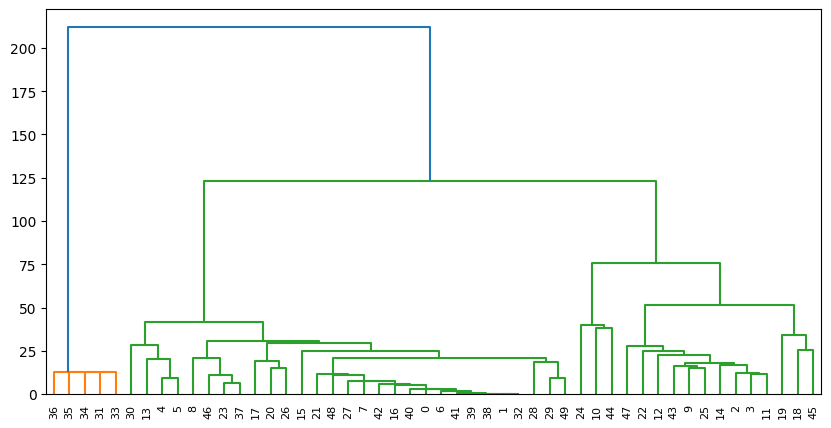

In [9]:
import scipy.cluster.hierarchy as sch
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, linkage

# convert similarity matrix to distance matrix
distance_matrix = 1 - similarity_matrix

# perform HAC using Ward's method
distance_matrix[~np.isfinite(distance_matrix)] = 10
linkage_matrix = sch.linkage(distance_matrix, method='ward')
# plot the dendrogram
fig = plt.figure(figsize=(10, 5))
dn = sch.dendrogram(linkage_matrix)

clusters = fcluster(linkage_matrix, 3, criterion='maxclust')
for i in range(1, len(set(clusters)) + 1):
    print(f'КЛАСТЕР {i}:')
    cluster_messages = [non_affected_documents[j] for j, c in enumerate(clusters) if c == i]
    for message in cluster_messages:
        print(message)
    print("\n")